In [11]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, GaussianMixture, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline  
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
spark = SparkSession \
    .builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/12/03 15:45:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in data
flights_2018 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2018.parquet')
flights_2019 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2019.parquet')
flights_2020 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2020.parquet')
flights_2021 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2021.parquet')
flights_2022 = spark.read.parquet('/standard/ds7200-apt4c/isaac_yuyang_final_project/flights_2022.parquet')

In [22]:
"""
Transform data so that each row is an airline and each column is a day. 
The value of each cell is the proportion of flights for that airline on that day 
that had an arrival delay >= 15 minutes.
""" 
remove = ['Cape Air', 'Commutair Aka Champlain Enterprises, Inc.', 'Peninsula Airways Inc.', 'Virgin America']
# Combine all years, select relevant columns, drop missing
combined = flights_2018.union(flights_2019).union(flights_2020).union(flights_2021).union(flights_2022) \
    .select('FlightDate', 'Airline', 'ArrDel15').dropna()

filtered = combined.filter(~combined['Airline'].isin(remove))
# Group by airline and date, calculate proportion of delayed flights
delay_prop = filtered.groupBy('Airline', 'FlightDate') \
                .agg(F.mean('ArrDel15').alias('delay_proportion'))

# Pivot so each airline is a row and each date is a column
pivoted = delay_prop.groupBy('Airline') \
            .pivot('FlightDate') \
            .agg(F.first('delay_proportion')) \
            .orderBy('Airline')

# Fill NA values with 0
data = pivoted.fillna(0)

print(f'Shape of transformed data: {data.count()} rows, {len(data.columns)} columns.')

[Stage 133:===================================================>   (28 + 2) / 30]

Shape of transformed data: 24 rows, 1674 columns.


In [23]:
# Create feature vector
feats = data.columns[1:]
assembler = VectorAssembler(inputCols=feats, outputCol='features')
dataset = assembler.transform(data)

# Show 5 rows
dataset.select('features').show(5)

[Stage 139:=====================================================> (29 + 1) / 30]

25/12/03 15:58:11 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 15:58:12 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 147:>                                                        (0 + 1) / 1]

25/12/03 15:58:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
+--------------------+
|            features|
+--------------------+
|[0.52662721893491...|
|[0.16359918200409...|
|[0.34600760456273...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
+--------------------+
only showing top 5 rows



In [24]:
# Create function to find optimal k
def kmeans_range(lower, upper, data):
    output = pd.DataFrame(columns=['k', 'silhouette'])
    evaluator = ClusteringEvaluator()
    
    # Loop thru k's
    for k in range(lower, upper+1, 1):
        # Instatiate with current k
        kmeans = KMeans().setK(k).setSeed(314).setMaxIter(20)
        
        # Fit
        model = kmeans.fit(data)
        
        # Predict
        preds = model.transform(data)
        
        # Calculate sil score
        sil = evaluator.evaluate(preds)

        # Append to output df
        output = pd.concat([output, pd.DataFrame(data={'k': [k], 'silhouette': [sil]})])
    
    return output.reset_index().drop(columns=['index'])

# Create function to find optimal k
def bkm_range(lower, upper, data):
    output = pd.DataFrame(columns=['k', 'silhouette'])
    evaluator = ClusteringEvaluator()
    
    # Loop thru k's
    for k in range(lower, upper+1, 1):
        # Instatiate with current k
        bkm = BisectingKMeans().setK(k).setSeed(314).setMaxIter(20)
        
        # Fit
        model = bkm.fit(data)
        
        # Predict
        preds = model.transform(data)
        
        # Calculate sil score
        sil = evaluator.evaluate(preds)

        # Append to output df
        output = pd.concat([output, pd.DataFrame(data={'k': [k], 'silhouette': [sil]})])
    
    return output.reset_index().drop(columns=['index'])

In [32]:
# Loop through various k values and view results
comparison_bkm = bkm_range(2, 10, dataset)

[Stage 1102:====================================================> (29 + 1) / 30]

25/12/03 16:04:49 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:04:50 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 1110:>                                                       (0 + 1) / 1]

25/12/03 16:04:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:04:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:04:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:04:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:04:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:04:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:04:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:04:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:04:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:04:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:04:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:04:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:04:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:04:54 WARN DAGScheduler: Broadcasting larg

[Stage 1220:====================================================> (29 + 1) / 30]

25/12/03 16:04:59 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:05:00 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 1228:>                                                       (0 + 1) / 1]

25/12/03 16:05:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1232:>                                                       (0 + 1) / 1]

25/12/03 16:05:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 1238:====================================================> (29 + 1) / 30]

25/12/03 16:05:06 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:05:06 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 1246:>                                                       (0 + 1) / 1]

25/12/03 16:05:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1252:====================================================> (29 + 1) / 30]

25/12/03 16:05:12 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:05:13 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 1260:>                                                       (0 + 1) / 1]

25/12/03 16:05:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1270:====================================================> (29 + 1) / 30]

25/12/03 16:05:18 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:05:19 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 1278:>                                                       (0 + 1) / 1]

25/12/03 16:05:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:05:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:05:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:23 WARN DAGScheduler: Broadcasting larg

[Stage 1488:====================================================> (29 + 1) / 30]

25/12/03 16:05:30 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:05:30 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 1496:>                                                       (0 + 1) / 1]

25/12/03 16:05:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1500:>                                                       (0 + 1) / 1]

25/12/03 16:05:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 1506:====================================================> (29 + 1) / 30]

25/12/03 16:05:36 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:05:37 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 1514:>                                                       (0 + 1) / 1]

25/12/03 16:05:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1520:====================================================> (29 + 1) / 30]

25/12/03 16:05:42 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:05:43 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 1528:>                                                       (0 + 1) / 1]

25/12/03 16:05:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1538:====================================================> (29 + 1) / 30]

25/12/03 16:05:48 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:05:49 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 1546:>                                                       (0 + 1) / 1]

25/12/03 16:05:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:05:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:05:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:05:53 WARN DAGScheduler: Broadcasting larg

[Stage 1756:====================================================> (29 + 1) / 30]

25/12/03 16:06:00 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:06:00 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 1764:>                                                       (0 + 1) / 1]

25/12/03 16:06:01 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1768:>                                                       (0 + 1) / 1]

25/12/03 16:06:02 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 1774:====================================================> (29 + 1) / 30]

25/12/03 16:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:06:07 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 1782:>                                                       (0 + 1) / 1]

25/12/03 16:06:08 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1788:====================================================> (29 + 1) / 30]

25/12/03 16:06:12 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:06:13 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 1796:>                                                       (0 + 1) / 1]

25/12/03 16:06:14 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1806:====================================================> (29 + 1) / 30]

25/12/03 16:06:18 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:06:19 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 1814:>                                                       (0 + 1) / 1]

25/12/03 16:06:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:06:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:06:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:23 WARN DAGScheduler: Broadcasting larg

[Stage 2124:====================================================> (29 + 1) / 30]

25/12/03 16:06:32 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:06:32 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 2132:>                                                       (0 + 1) / 1]

25/12/03 16:06:33 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 2136:>                                                       (0 + 1) / 1]

25/12/03 16:06:34 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 2142:====================================================> (29 + 1) / 30]

25/12/03 16:06:38 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 2150:>                                                       (0 + 1) / 1]

25/12/03 16:06:40 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 2156:====================================================> (29 + 1) / 30]

25/12/03 16:06:44 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:06:45 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 2164:>                                                       (0 + 1) / 1]

25/12/03 16:06:46 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 2174:====================================================> (29 + 1) / 30]

25/12/03 16:06:50 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:06:51 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 2182:>                                                       (0 + 1) / 1]

25/12/03 16:06:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:06:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:06:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:06:55 WARN DAGScheduler: Broadcasting larg

[Stage 2492:====================================================> (29 + 1) / 30]

25/12/03 16:07:04 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:07:05 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 2500:>                                                       (0 + 1) / 1]

25/12/03 16:07:06 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 2504:>                                                       (0 + 1) / 1]

25/12/03 16:07:07 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 2510:====================================================> (29 + 1) / 30]

25/12/03 16:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:07:12 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 2518:>                                                       (0 + 1) / 1]

25/12/03 16:07:13 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 2524:====================================================> (29 + 1) / 30]

25/12/03 16:07:17 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:07:18 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 2532:>                                                       (0 + 1) / 1]

25/12/03 16:07:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 2542:====================================================> (29 + 1) / 30]

25/12/03 16:07:24 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:07:24 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 2550:>                                                       (0 + 1) / 1]

25/12/03 16:07:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:07:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:07:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:07:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:07:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:07:28 WARN DAGScheduler: Broadcasting larg

[Stage 2860:====================================================> (29 + 1) / 30]

25/12/03 16:07:38 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:07:38 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 2868:>                                                       (0 + 1) / 1]

25/12/03 16:07:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2872:>                                                       (0 + 1) / 1]

25/12/03 16:07:40 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 2878:====================================================> (29 + 1) / 30]

25/12/03 16:07:44 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:07:45 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 2886:>                                                       (0 + 1) / 1]

25/12/03 16:07:46 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2892:====================================================> (29 + 1) / 30]

25/12/03 16:07:51 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:07:52 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 2900:>                                                       (0 + 1) / 1]

25/12/03 16:07:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 2910:====================================================> (29 + 1) / 30]

25/12/03 16:07:57 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 2918:>                                                       (0 + 1) / 1]

25/12/03 16:07:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:07:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:08:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:01 WARN DAGScheduler: Broadcasting larg

[Stage 3228:====================================================> (29 + 1) / 30]

25/12/03 16:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:08:11 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 3236:>                                                       (0 + 1) / 1]

25/12/03 16:08:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3240:>                                                       (0 + 1) / 1]

25/12/03 16:08:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[Stage 3246:====================================================> (29 + 1) / 30]

25/12/03 16:08:17 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:08:18 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 3254:>                                                       (0 + 1) / 1]

25/12/03 16:08:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3260:====================================================> (29 + 1) / 30]

25/12/03 16:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:08:24 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 3268:>                                                       (0 + 1) / 1]

25/12/03 16:08:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3278:====================================================> (29 + 1) / 30]

25/12/03 16:08:29 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:08:30 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 3286:>                                                       (0 + 1) / 1]

25/12/03 16:08:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:08:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:08:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:08:34 WARN DAGScheduler: Broadcasting larg

[Stage 3696:====================================================> (29 + 1) / 30]

25/12/03 16:08:45 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:08:46 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 3704:>                                                       (0 + 1) / 1]

25/12/03 16:08:47 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3708:>                                                       (0 + 1) / 1]

25/12/03 16:08:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[Stage 3714:====================================================> (29 + 1) / 30]

25/12/03 16:08:52 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:08:52 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 3722:>                                                       (0 + 1) / 1]

25/12/03 16:08:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3728:====================================================> (29 + 1) / 30]

25/12/03 16:08:58 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 3736:>                                                       (0 + 1) / 1]

25/12/03 16:08:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 3746:====================================================> (29 + 1) / 30]

25/12/03 16:09:04 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:09:05 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 3754:>                                                       (0 + 1) / 1]

25/12/03 16:09:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:09:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:09:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:09:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:09:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:09:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:09:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:09:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:09:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:09:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:09:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:09:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:09:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:09:09 WARN DAGScheduler: Broadcasting larg

[Stage 4164:====================================================> (29 + 1) / 30]

25/12/03 16:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:09:21 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 4172:>                                                       (0 + 1) / 1]

25/12/03 16:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 4176:>                                                       (0 + 1) / 1]

25/12/03 16:09:22 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[Stage 4182:====================================================> (29 + 1) / 30]

25/12/03 16:09:26 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 4190:>                                                       (0 + 1) / 1]

25/12/03 16:09:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 4196:====================================================> (29 + 1) / 30]

25/12/03 16:09:33 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:09:33 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 4204:>                                                       (0 + 1) / 1]

25/12/03 16:09:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [33]:
comparison_bkm

,k,silhouette
0,2,0.254116
1,3,0.277184
2,4,0.221033
3,5,0.221184
4,6,0.146411
5,7,0.165833
6,8,0.152536
7,9,0.179993
8,10,0.090835


In [25]:
# Loop through various k values and view results
comparison_km = kmeans_range(2, 10, dataset)

[Stage 152:=====================================================> (29 + 1) / 30]

25/12/03 15:58:25 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 15:58:26 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 161:=====================================================> (29 + 1) / 30]

25/12/03 15:58:30 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 15:58:31 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 169:>                                                        (0 + 1) / 1]

25/12/03 15:58:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 15:58:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:58:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:58:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:58:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:58:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:58:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:58:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:58:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 209:=====================================================> (29 + 1) / 30]

25/12/03 15:58:38 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 15:58:39 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 217:>                                                        (0 + 1) / 1]

25/12/03 15:58:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 221:>                                                        (0 + 1) / 1]

25/12/03 15:58:41 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 227:=====================================================> (29 + 1) / 30]

25/12/03 15:58:45 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 15:58:46 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 235:>                                                        (0 + 1) / 1]

25/12/03 15:58:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 241:=====================================================> (29 + 1) / 30]

25/12/03 15:58:51 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 15:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 249:>                                                        (0 + 1) / 1]

25/12/03 15:58:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 259:=====================================================> (29 + 1) / 30]

25/12/03 15:58:57 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 15:58:58 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 267:>                                                        (0 + 1) / 1]

25/12/03 15:58:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 15:59:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 307:=====================================================> (29 + 1) / 30]

25/12/03 15:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 15:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 315:>                                                        (0 + 1) / 1]

25/12/03 15:59:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 319:>                                                        (0 + 1) / 1]

25/12/03 15:59:08 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 325:=====================================================> (29 + 1) / 30]

25/12/03 15:59:12 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 15:59:13 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 333:>                                                        (0 + 1) / 1]

25/12/03 15:59:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 339:=====================================================> (29 + 1) / 30]

25/12/03 15:59:18 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 15:59:19 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 347:>                                                        (0 + 1) / 1]

25/12/03 15:59:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 357:=====================================================> (29 + 1) / 30]

25/12/03 15:59:25 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 15:59:25 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 365:>                                                        (0 + 1) / 1]

25/12/03 15:59:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 15:59:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 405:=====================================================> (29 + 1) / 30]

25/12/03 15:59:33 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 15:59:34 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 413:>                                                        (0 + 1) / 1]

25/12/03 15:59:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 417:>                                                        (0 + 1) / 1]

25/12/03 15:59:35 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 423:=====================================================> (29 + 1) / 30]

25/12/03 15:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 15:59:40 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 431:>                                                        (0 + 1) / 1]

25/12/03 15:59:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 437:=====================================================> (29 + 1) / 30]

25/12/03 15:59:46 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 15:59:46 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 445:>                                                        (0 + 1) / 1]

25/12/03 15:59:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 455:=====================================================> (29 + 1) / 30]

25/12/03 15:59:52 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 15:59:53 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 463:>                                                        (0 + 1) / 1]

25/12/03 15:59:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 15:59:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 15:59:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 503:=====================================================> (29 + 1) / 30]

25/12/03 16:00:00 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:00:01 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 511:>                                                        (0 + 1) / 1]

25/12/03 16:00:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 515:>                                                        (0 + 1) / 1]

25/12/03 16:00:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 521:=====================================================> (29 + 1) / 30]

25/12/03 16:00:07 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:00:07 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 529:>                                                        (0 + 1) / 1]

25/12/03 16:00:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 535:=====================================================> (29 + 1) / 30]

25/12/03 16:00:13 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:00:14 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 543:>                                                        (0 + 1) / 1]

25/12/03 16:00:15 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 553:=====================================================> (29 + 1) / 30]

25/12/03 16:00:19 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:00:20 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 561:>                                                        (0 + 1) / 1]

25/12/03 16:00:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:00:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 601:=====================================================> (29 + 1) / 30]

25/12/03 16:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:00:28 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 609:>                                                        (0 + 1) / 1]

25/12/03 16:00:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 613:>                                                        (0 + 1) / 1]

25/12/03 16:00:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 619:=====================================================> (29 + 1) / 30]

25/12/03 16:00:34 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:00:34 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 627:>                                                        (0 + 1) / 1]

25/12/03 16:00:35 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 633:=====================================================> (29 + 1) / 30]

25/12/03 16:00:40 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:00:41 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 641:>                                                        (0 + 1) / 1]

25/12/03 16:00:42 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 651:=====================================================> (29 + 1) / 30]

25/12/03 16:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:00:47 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 659:>                                                        (0 + 1) / 1]

25/12/03 16:00:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:00:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:00:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 694:=====================================================> (29 + 1) / 30]

25/12/03 16:00:54 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:00:55 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 702:>                                                        (0 + 1) / 1]

25/12/03 16:00:56 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/12/03 16:00:57 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 712:=====================================================> (29 + 1) / 30]

25/12/03 16:01:01 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:01:01 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 720:>                                                        (0 + 1) / 1]

25/12/03 16:01:02 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 726:=====================================================> (29 + 1) / 30]

25/12/03 16:01:07 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 734:>                                                        (0 + 1) / 1]

25/12/03 16:01:09 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 744:=====================================================> (29 + 1) / 30]

25/12/03 16:01:13 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:01:14 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 752:>                                                        (0 + 1) / 1]

25/12/03 16:01:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:01:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 787:=====================================================> (29 + 1) / 30]

25/12/03 16:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:01:22 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 795:>                                                        (0 + 1) / 1]

25/12/03 16:01:23 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 799:>                                                        (0 + 1) / 1]

25/12/03 16:01:23 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 805:=====================================================> (29 + 1) / 30]

25/12/03 16:01:28 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:01:28 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 813:>                                                        (0 + 1) / 1]

25/12/03 16:01:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 819:=====================================================> (29 + 1) / 30]

25/12/03 16:01:34 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:01:34 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 827:>                                                        (0 + 1) / 1]

25/12/03 16:01:35 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 837:=====================================================> (29 + 1) / 30]

25/12/03 16:01:40 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:01:41 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 845:>                                                        (0 + 1) / 1]

25/12/03 16:01:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:01:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:01:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 880:=====================================================> (29 + 1) / 30]

25/12/03 16:01:48 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:01:48 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 888:>                                                        (0 + 1) / 1]

25/12/03 16:01:49 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 892:>                                                        (0 + 1) / 1]

25/12/03 16:01:50 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 898:=====================================================> (29 + 1) / 30]

25/12/03 16:01:54 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:01:55 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 906:>                                                        (0 + 1) / 1]

25/12/03 16:01:56 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 912:=====================================================> (29 + 1) / 30]

25/12/03 16:02:00 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:02:01 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 920:>                                                        (0 + 1) / 1]

25/12/03 16:02:02 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 930:=====================================================> (29 + 1) / 30]

25/12/03 16:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:02:07 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 938:>                                                        (0 + 1) / 1]

25/12/03 16:02:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:02:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:02:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:02:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:02:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:02:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:02:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:02:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 973:=====================================================> (29 + 1) / 30]

25/12/03 16:02:14 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:02:15 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 981:>                                                        (0 + 1) / 1]

25/12/03 16:02:16 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 985:>                                                        (0 + 1) / 1]

25/12/03 16:02:17 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


[Stage 991:=====================================================> (29 + 1) / 30]

25/12/03 16:02:21 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:02:22 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 999:>                                                        (0 + 1) / 1]

25/12/03 16:02:23 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


[Stage 1005:====================================================> (29 + 1) / 30]

25/12/03 16:02:27 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:02:28 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 1013:>                                                       (0 + 1) / 1]

25/12/03 16:02:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


In [27]:
comparison_km

,k,silhouette
0,2,0.460894
1,3,0.168301
2,4,0.228832
3,5,0.207649
4,6,0.170245
5,7,0.185133
6,8,0.139876
7,9,0.090524
8,10,0.150821


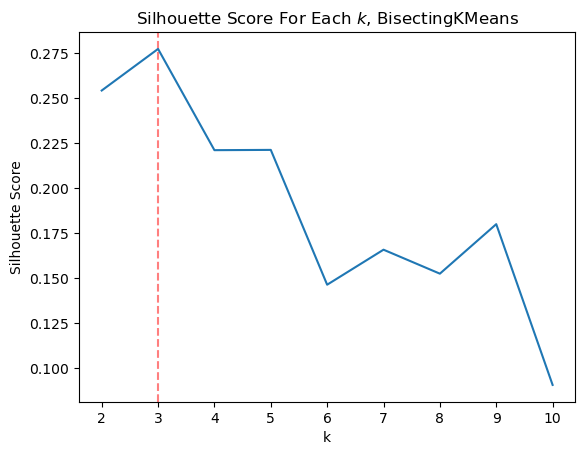

In [34]:
# Visualize
x=comparison_bkm.k
y=comparison_bkm.silhouette
optimal_k = comparison_bkm.loc[comparison_bkm['silhouette'].idxmax(), 'k']
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.5, label=f'Optimal k={int(optimal_k)}')
plt.plot(x, y)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Each $k$, BisectingKMeans')
plt.savefig('airline_bkm_silhouette_scores.png')
plt.show()

In [29]:
# Refit with k=2
kmeans = KMeans().setK(2).setSeed(314).setMaxIter(20)
# Fit
model = kmeans.fit(dataset)
        
# Predict
preds = model.transform(dataset)

[Stage 1023:====================================================> (29 + 1) / 30]

25/12/03 16:03:50 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:03:51 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 1031:>                                                       (0 + 1) / 1]

25/12/03 16:03:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:03:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:03:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:03:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:03:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:03:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:03:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:03:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:03:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1071:====================================================> (29 + 1) / 30]

25/12/03 16:03:58 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 1079:>                                                       (0 + 1) / 1]

25/12/03 16:04:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 1083:>                                                       (0 + 1) / 1]

25/12/03 16:04:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [36]:
# Refit with k=3
bkm = BisectingKMeans().setK(3).setSeed(314).setMaxIter(20)
# Fit
model = bkm.fit(dataset)
        
# Predict
preds = model.transform(dataset)

[Stage 4214:====================================================> (29 + 1) / 30]

25/12/03 16:11:26 WARN DAGScheduler: Broadcasting large task binary with size 1474.3 KiB


25/12/03 16:11:26 WARN DAGScheduler: Broadcasting large task binary with size 1476.0 KiB


[Stage 4222:>                                                       (0 + 1) / 1]

25/12/03 16:11:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:11:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 16:11:29 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:11:29 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:11:29 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:11:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:11:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:11:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:11:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:11:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:11:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:11:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:11:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 16:11:30 WARN DAGScheduler: Broadcasting larg

[Stage 4432:====================================================> (29 + 1) / 30]

25/12/03 16:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:11:38 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 4440:>                                                       (0 + 1) / 1]

25/12/03 16:11:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 4444:>                                                       (0 + 1) / 1]

25/12/03 16:11:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [19]:
preds.select('Airline', 'prediction').orderBy('prediction').show(30, truncate=False)

[Stage 1021:====================================================> (29 + 1) / 30]

25/12/03 01:52:47 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 01:52:48 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 1029:>                                                       (0 + 1) / 1]

25/12/03 01:52:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
+----------------------------------------+----------+
|Airline                                 |prediction|
+----------------------------------------+----------+
|Trans States Airlines                   |0         |
|Compass Airlines                        |0         |
|Empire Airlines Inc.                    |0         |
|ExpressJet Airlines Inc.                |0         |
|Allegiant Air                           |1         |
|Frontier Airlines Inc.                  |1         |
|GoJet Airlines, LLC d/b/a United Express|1         |
|Southwest Airlines Co.                  |1         |
|JetBlue Airways                         |1         |
|Spirit Air Lines                        |1         |
|Delta Air Lines Inc.                    |2         |
|Air Wisconsin Airlines Corp             |2         |
|Endeavor Air Inc.                       |2         |
|Horizon Air                             |2       

In [30]:
km_preds = preds.toPandas()

[Stage 1089:====================================================> (29 + 1) / 30]

25/12/03 16:04:07 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:04:08 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 1097:>                                                       (0 + 1) / 1]

25/12/03 16:04:09 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


In [37]:
bkm_preds = preds.toPandas()

[Stage 4450:====================================================> (29 + 1) / 30]

25/12/03 16:11:49 WARN DAGScheduler: Broadcasting large task binary with size 1476.9 KiB


25/12/03 16:11:50 WARN DAGScheduler: Broadcasting large task binary with size 1478.6 KiB


[Stage 4458:>                                                       (0 + 1) / 1]

25/12/03 16:11:51 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


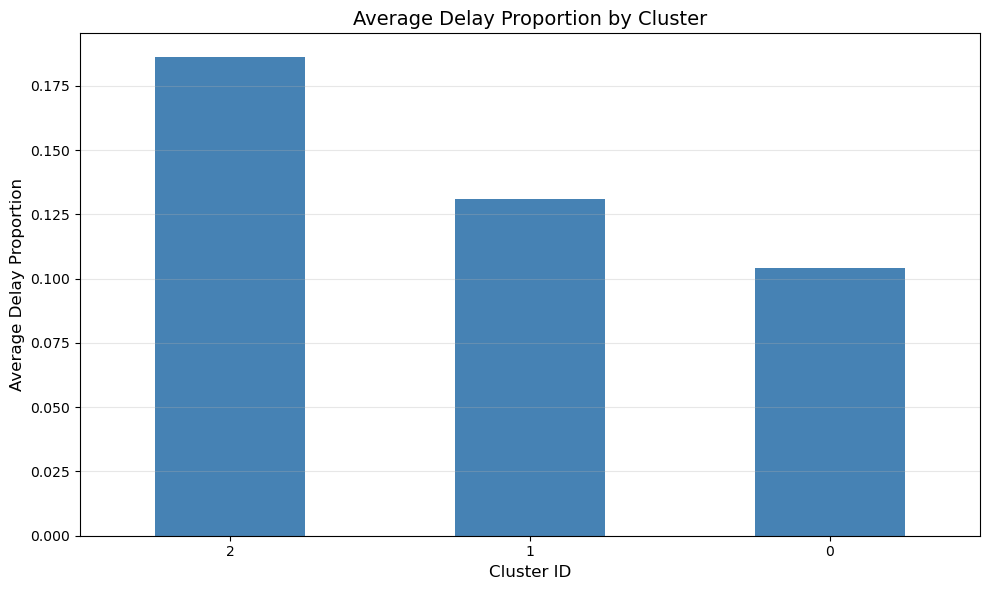

In [38]:
# Calculate average delay proportion per cluster
cluster_stats = bkm_preds.groupby('prediction')[feats].mean().mean(axis=1)
cluster_stats = cluster_stats.sort_values(ascending=False)

# Visualize cluster delay patterns
plt.figure(figsize=(10, 6))
cluster_stats.plot(kind='bar', color='steelblue')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Average Delay Proportion', fontsize=12)
plt.title('Average Delay Proportion by Cluster', fontsize=14)
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('airline_clustering_delay_proportion_bisectingkmeans.png')
plt.show()

#### So with $k=4$, which has the highest silhouette score, we can see how each airline is clustered. Virginia America is the only airline in group 4, so could be worth exploring the clusters.

In [39]:
# Refit with k=2
bkm = BisectingKMeans().setK(2).setSeed(314).setMaxIter(20)
# Fit
model_bkm = bkm.fit(dataset)
        
# Predict
preds_bkm = model_bkm.transform(dataset)

preds_bkm.select('Airline', 'prediction').orderBy('prediction').show(30, truncate=False)

[Stage 4226:====================================================> (29 + 1) / 30]

25/12/03 02:22:21 WARN DAGScheduler: Broadcasting large task binary with size 1474.1 KiB


25/12/03 02:22:22 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB


[Stage 4234:>                                                       (0 + 1) / 1]

25/12/03 02:22:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:22:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/12/03 02:22:26 WARN DAGScheduler: Broadcasting larg

[Stage 4344:====================================================> (29 + 1) / 30]

25/12/03 02:22:31 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 4352:>                                                       (0 + 1) / 1]

25/12/03 02:22:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Stage 4356:>                                                       (0 + 1) / 1]

25/12/03 02:22:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


[Stage 4362:====================================================> (29 + 1) / 30]

25/12/03 02:22:38 WARN DAGScheduler: Broadcasting large task binary with size 1476.6 KiB


25/12/03 02:22:39 WARN DAGScheduler: Broadcasting large task binary with size 1478.2 KiB


[Stage 4370:>                                                       (0 + 1) / 1]

25/12/03 02:22:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
+----------------------------------------+----------+
|Airline                                 |prediction|
+----------------------------------------+----------+
|Capital Cargo International             |0         |
|Delta Air Lines Inc.                    |0         |
|Hawaiian Airlines Inc.                  |0         |
|Horizon Air                             |0         |
|Empire Airlines Inc.                    |0         |
|Trans States Airlines                   |0         |
|Virgin America                          |0         |
|Compass Airlines                        |0         |
|Endeavor Air Inc.                       |0         |
|ExpressJet Airlines Inc.                |0         |
|Air Wisconsin Airlines Corp             |1         |
|Envoy Air                               |1         |
|Alaska Airlines Inc.                    |1         |
|Frontier Airlines Inc.                  |1       